In [1]:
#import our library
import copy 
import warnings
import numpy as np 
import scipy.sparse 
import math 
import nltk
from nltk.tokenize import RegexpTokenizer
from sklearn import preprocessing 
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import make_scorer

In [2]:
#define onehot key for our target
def to_onehot(Y): 
    #Y = np.asmatrix(Y.shape).T
    m = Y.shape[0] 
    OHX = scipy.sparse.csr_matrix((np.ones(m), (Y[:], np.array(range(m))))) 
    OHX = np.array(OHX.todense()).T 
    return OHX

In [3]:
#import our 3 datasets and split randomly
def load_data(set_type, test_size):
    if   set_type == 'amazon':
        dataset = np.loadtxt('amazon.txt', delimiter = '\t', dtype='str') 
    elif set_type == 'imdb':
        dataset = np.loadtxt('imdb.txt', delimiter = '\t', dtype='str')
    elif set_type == 'yelp':
        dataset = np.loadtxt('yelp.txt', delimiter = '\t', dtype='str')
        
    x = dataset[:,0]
    y = dataset[:,1].astype(np.int)
        
    k = len(np.unique(y))

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=20)
    
    m = X_train.shape[0]
    m_test = X_test.shape[0]
    
    X_train = np.asarray([xx.lower() for xx in X_train]).T
    X_test = np.asarray([xx.lower() for xx in X_test]).T    
    
    return X_train, y_train, m, X_test, y_test, m_test, k

In [4]:
#read all words in data and processing
def get_dict(sentences):
    tokenizer = RegexpTokenizer(r'\w+')
    allwords = []
    for s in sentences:
        allwords += tokenizer.tokenize(s)
    words = list(set(allwords))
    m = len(words)
    return words, m

def get_words(text):
    tokenizer = RegexpTokenizer(r'\w+')
    allwords = []
    #for s in text:
    allwords = tokenizer.tokenize(text)
    words = list(set(allwords))
    m = len(words)
    return words, m

In [5]:
#main function
def learn(m, n, k, dict, sentences, labels):    
    #----------------
    onehot_labels = to_onehot(labels)
    #----------------
    words_count = np.zeros((m, n))
    for j in range(0, m):
        for i in range(0, n):
            s_words, s_words_n = get_words(sentences[j])
            words_count[j, i] = s_words.count(dict[i])
    #print('sentences[0]=',sentences[0])
    #print('words_count[0].sum()=', words_count[0].sum())
    #----------------
    py = np.zeros((k, 1))
    py[0] = onehot_labels[:,0].sum()/m
    py[1] = onehot_labels[:,1].sum()/m
    #print('py=', py)
    #----------------
    ny = np.zeros((k, 1))
    ny[0] = words_count[onehot_labels[:,0]==1].sum()
    ny[1] = words_count[onehot_labels[:,1]==1].sum()
    #print('ny=', ny)
    #----------------
    n_dict = n
    #print('n_dict=', n_dict)
    #----------------
    # Laplace smoothing
    alpha = 1
    #----------------
    pxy = np.zeros((n,k))
    nxy = np.zeros((k, 1))
    for c in range(0, k):
        for i in range(0, n):
            nxy[c] = words_count[onehot_labels[:, c]==1][:, i].sum()
            pxy[i, c] = (nxy[c] + alpha) / (ny[c] + alpha*n_dict)
    #print('pxy=', pxy)
    #----------------
    return pxy, py

In [6]:
#define our predict function
def predict(dict, k, pxy, py, new_sentences):    
    #----------------
    m = len(new_sentences)    
    #----------------
    pyx = np.zeros((m,k))
    for c in range(0, k):
        for j in range(0, m):
            words, n_words = get_words(new_sentences[j])
            temp = 0
            pyx[j, c] = np.log10(py[c])
            for i in range(0, n_words):
                if words[i] in dict:
                    temp += np.log10(pxy[dict.index(words[i]), c])
            pyx[j, c] += temp
    #print(pyx)
    #----------------
    y_pred = np.argmax(pyx, axis=1)
    y_score = np.max(pyx, axis=1)
    #print('y_pred=', y_pred)
    #----------------
    return y_pred, y_score


----------------------DataSet "amazon"-----------------------
Total Train Accuracy =  0.9637046307884856
Total Test Accuracy =  0.815
--------------------Classification Report--------------------
              precision    recall  f1-score   support

    Negative       0.76      0.84      0.80        88
    Positive       0.86      0.79      0.83       112

    accuracy                           0.81       200
   macro avg       0.81      0.82      0.81       200
weighted avg       0.82      0.81      0.82       200



NameError: name 'plt' is not defined

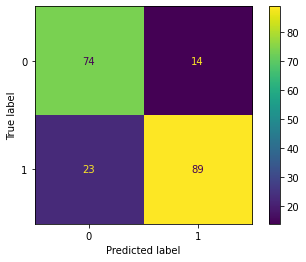

In [7]:
#calculate and define (amazon dataset)
def NaiveBayes(dataset):
    #--------------------------------DataSet1----------------------------------#
    #-----------------LoadData-----------------#    
    sentences, labels, m, sentences_test, labels_test, m_test, k = load_data(set_type = dataset, test_size=0.2)
    dict, n = get_dict(sentences)
    #print('sentences[0:10]=',sentences[0:10])
    #print('labels[0:10]=',labels[0:10])
    #-----------------Learning-----------------#
    pxy, py = learn(m, n, k, dict, sentences, labels)
    #-----------------Predict------------------#
    y_pred, y_score = predict(dict, k, pxy, py, sentences)    
    y_pred_test, y_score_test  = predict(dict, k, pxy, py, sentences_test)
    #print('y_pred[0:10]=',y_pred[0:10])
    #-----------------Results------------------#
    target_names = np.array(['Negative','Positive'])
    total_train_accuracy = accuracy_score(labels, y_pred)
    total_test_accuracy = accuracy_score(labels_test, y_pred_test)
    print('----------------------DataSet "'+dataset+'"-----------------------')
    print('Total Train Accuracy = ',total_train_accuracy)
    print('Total Test Accuracy = ',total_test_accuracy)
    print('--------------------Classification Report--------------------')
    print(classification_report(labels_test, y_pred_test, target_names=target_names))  
    cm_test = confusion_matrix(labels_test, y_pred_test)
    cm_display = ConfusionMatrixDisplay(cm_test).plot()
    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    #fpr, tpr, thresholds = roc_curve(labels_test, y_score_test)
    #roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax1)
    #prec, recall, thresholds = precision_recall_curve(labels_test, y_score_test)
    #pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax2)
    plt.show()
    #--------------------------------------------------------------------------#

    
    
NaiveBayes('amazon')

----------------------DataSet "imdb"-----------------------
Total Train Accuracy =  0.9625
Total Test Accuracy =  0.795
--------------------Classification Report--------------------
              precision    recall  f1-score   support

    Negative       0.76      0.86      0.81       101
    Positive       0.84      0.73      0.78        99

    accuracy                           0.80       200
   macro avg       0.80      0.79      0.79       200
weighted avg       0.80      0.80      0.79       200



NameError: name 'plt' is not defined

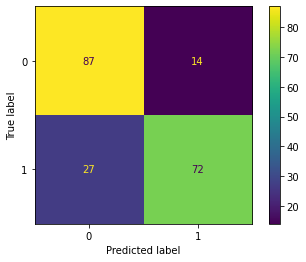

In [8]:
#calculate and define (imdb dataset)
def NaiveBayes(dataset):
    #--------------------------------DataSet1----------------------------------#
    #-----------------LoadData-----------------#    
    sentences, labels, m, sentences_test, labels_test, m_test, k = load_data(set_type = dataset, test_size=0.2)
    dict, n = get_dict(sentences)
    #print('sentences[0:10]=',sentences[0:10])
    #print('labels[0:10]=',labels[0:10])
    #-----------------Learning-----------------#
    pxy, py = learn(m, n, k, dict, sentences, labels)
    #-----------------Predict------------------#
    y_pred, y_score = predict(dict, k, pxy, py, sentences)    
    y_pred_test, y_score_test  = predict(dict, k, pxy, py, sentences_test)
    #print('y_pred[0:10]=',y_pred[0:10])
    #-----------------Results------------------#
    target_names = np.array(['Negative','Positive'])
    total_train_accuracy = accuracy_score(labels, y_pred)
    total_test_accuracy = accuracy_score(labels_test, y_pred_test)
    print('----------------------DataSet "'+dataset+'"-----------------------')
    print('Total Train Accuracy = ',total_train_accuracy)
    print('Total Test Accuracy = ',total_test_accuracy)
    print('--------------------Classification Report--------------------')
    print(classification_report(labels_test, y_pred_test, target_names=target_names))  
    cm_test = confusion_matrix(labels_test, y_pred_test)
    cm_display = ConfusionMatrixDisplay(cm_test).plot()
    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    #fpr, tpr, thresholds = roc_curve(labels_test, y_score_test)
    #roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax1)
    #prec, recall, thresholds = precision_recall_curve(labels_test, y_score_test)
    #pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax2)
    plt.show()
    #--------------------------------------------------------------------------# 

    
    
NaiveBayes('imdb')

----------------------DataSet "yelp"-----------------------
Total Train Accuracy =  0.94625
Total Test Accuracy =  0.8
--------------------Classification Report--------------------
              precision    recall  f1-score   support

    Negative       0.81      0.79      0.80       102
    Positive       0.79      0.81      0.80        98

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.80       200
weighted avg       0.80      0.80      0.80       200



NameError: name 'plt' is not defined

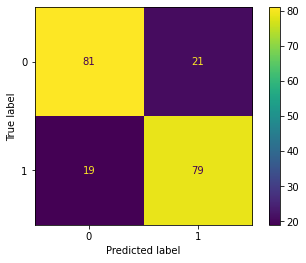

In [9]:
#calculate and define (yelp dataset)
def NaiveBayes(dataset):
    #--------------------------------DataSet1----------------------------------#
    #-----------------LoadData-----------------#    
    sentences, labels, m, sentences_test, labels_test, m_test, k = load_data(set_type = dataset, test_size=0.2)
    dict, n = get_dict(sentences)
    #print('sentences[0:10]=',sentences[0:10])
    #print('labels[0:10]=',labels[0:10])
    #-----------------Learning-----------------#
    pxy, py = learn(m, n, k, dict, sentences, labels)
    #-----------------Predict------------------#
    y_pred, y_score = predict(dict, k, pxy, py, sentences)    
    y_pred_test, y_score_test  = predict(dict, k, pxy, py, sentences_test)
    #print('y_pred[0:10]=',y_pred[0:10])
    #-----------------Results------------------#
    target_names = np.array(['Negative','Positive'])
    total_train_accuracy = accuracy_score(labels, y_pred)
    total_test_accuracy = accuracy_score(labels_test, y_pred_test)
    print('----------------------DataSet "'+dataset+'"-----------------------')
    print('Total Train Accuracy = ',total_train_accuracy)
    print('Total Test Accuracy = ',total_test_accuracy)
    print('--------------------Classification Report--------------------')
    print(classification_report(labels_test, y_pred_test, target_names=target_names))  
    cm_test = confusion_matrix(labels_test, y_pred_test)
    cm_display = ConfusionMatrixDisplay(cm_test).plot()
    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    #fpr, tpr, thresholds = roc_curve(labels_test, y_score_test)
    #roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax1)
    #prec, recall, thresholds = precision_recall_curve(labels_test, y_score_test)
    #pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax2)
    plt.show()
    #--------------------------------------------------------------------------#

    

NaiveBayes('yelp')